# Time features extraction

Time feature is a time since the last annotation.<br>
It was computed for each timestamp/frame and extracted for various annotation types.

In [1]:
import glob
import pympi
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_folder = f'/home/janko/Desktop/social-dining/data'

annotations_folder = f'{data_folder}/annotation/annotation-files'
videos_folder = f'{data_folder}/raw/video'

time_features_folder =  f'{data_folder}/processed/time-features'

# Frame rate of time features
FPS = 30.
DT = 1 / FPS


In [2]:
annotation_types = [
    'food_lifted',
    'food_to_mouth'
]

# Methods to generate time features within annotations
#
#     increase_within_annotation: ignore annotation duration and start increasing the time since last annotation immediately after the annotation start time 
#
#     zero_within_annotation:     set the time since last annotation to zero during the annotation, 
#                                 this option is only relevant for variable-length annotations (mouth_open, food_to_mouth, drink_to_mouth, napkin_to_mouth),
#                                 the output folder has a suffix '-zeroed'

def increase_within_annotation(t, times_since_last_annotation, annotation_start_time, annotation_end_time):
    return t, annotation_start_time, times_since_last_annotation

def zero_within_annotation(t, times_since_last_annotation, annotation_start_time, annotation_end_time):
    while t <= annotation_end_time:
        times_since_last_annotation.append(0.)
        t += DT
    return t, annotation_end_time, times_since_last_annotation

plot_data = []
for annotation_file in glob.glob(f'{annotations_folder}/*.eaf'):
    eaf_obj1 = pympi.Elan.Eaf(annotation_file)
    video_id = annotation_file.split('/')[-1].split('.')[0]
    video_data = cv2.VideoCapture(f'{videos_folder}/{video_id}.mp4')
    total_num_frames = video_data.get(cv2.CAP_PROP_FRAME_COUNT)

    for annotation_type in annotation_types:
        annotations = sorted(eaf_obj1.get_annotation_data_for_tier(annotation_type), key=lambda x: x[0])

        process_within_annotation_funcs = [increase_within_annotation]
        if annotation_type in ['mouth_open', 'food_to_mouth', 'drink_to_mouth', 'napkin_to_mouth']:
            process_within_annotation_funcs.append(zero_within_annotation)
        
        for process_within_annotation in process_within_annotation_funcs:
            t = 0.
            annotation_idx = 0
            last_annotation_time = 0.
            times_since_last_annotation = []

            while len(times_since_last_annotation) < int(total_num_frames):
                if annotation_idx < len(annotations):
                    annotation_start_time = annotations[annotation_idx][0] / 1000.
                    if t >= annotation_start_time:
                        t, last_annotation_time, times_since_last_annotation = process_within_annotation(t, times_since_last_annotation, 
                                                                                                         annotation_start_time, annotations[annotation_idx][1] / 1000.)
                        annotation_idx += 1
                times_since_last_annotation.append( t - last_annotation_time )
                t += DT

            timestamps = np.arange(len(times_since_last_annotation)) * DT

            # Log data for visualization
            if video_id == '01_3':
                plot_data.append( (timestamps / 60., 
                                   times_since_last_annotation, 
                                   f"{annotation_type}{' (zeroed during annotation)' if process_within_annotation == zero_within_annotation else ''}") )

            # Save time features as .csv file, one per video
            pd.DataFrame({
                'Timestamp (s)': timestamps,
                f'Time since last {annotation_type} (s)': times_since_last_annotation
            }).to_csv(f"{time_features_folder}/time-since-last-{annotation_type.replace('_', '-')}{'-zeroed' if process_within_annotation == zero_within_annotation else ''}/{video_id}.csv", index=False)


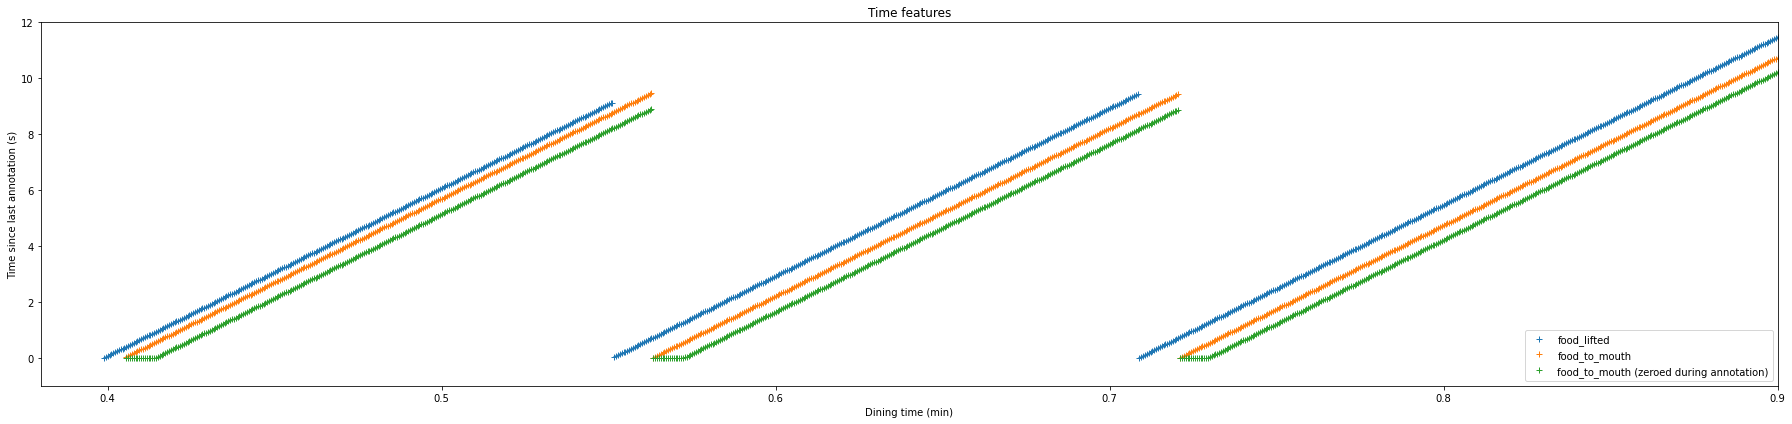

In [3]:
plt.figure(figsize=(25, 6))
for x, y, label in plot_data:
    plt.plot(x, y, '+', label=label)
plt.xlim(0.38, 0.9)
plt.ylim(-1, 12)
plt.xlabel('Dining time (min)')
plt.ylabel(f'Time since last annotation (s)')
plt.title(f"Time features")
plt.legend()
plt.tight_layout()
plt.show()
